In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
!pip install mediapipe

In [54]:
import cv2
import numpy as np
import h5py
import mediapipe as mp
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter
from google.colab.patches import cv2_imshow
from scipy.signal import find_peaks, butter, filtfilt

In [60]:
# HDF5 파일 경로
hdf5_file_path = "/content/drive/MyDrive/everglow/cohface/5/1/data.hdf5"

# HDF5 파일 열기 (읽기 모드)
with h5py.File(hdf5_file_path, 'r') as file:
    # 각 데이터셋 읽기
    pulse_dataset = file['pulse'][:]
    respiration_dataset = file['respiration'][:]
    time_dataset = file['time'][:]

    # 데이터셋 확인
    print("Pulse dataset shape:", pulse_dataset.shape)
    print("Respiration dataset shape:", respiration_dataset.shape)
    print("Time dataset shape:", time_dataset.shape)

    # 데이터셋 내용 출력 또는 처리
    # 예시로 각 데이터셋의 첫 번째 값 출력
    print("First value of pulse dataset:", pulse_dataset[0])
    print("First value of respiration dataset:", respiration_dataset[0])
    print("First value of time dataset:", time_dataset[0])


Pulse dataset shape: (15488,)
Respiration dataset shape: (15488,)
Time dataset shape: (15488,)
First value of pulse dataset: 0.007
First value of respiration dataset: 9.933
First value of time dataset: 0.00390625


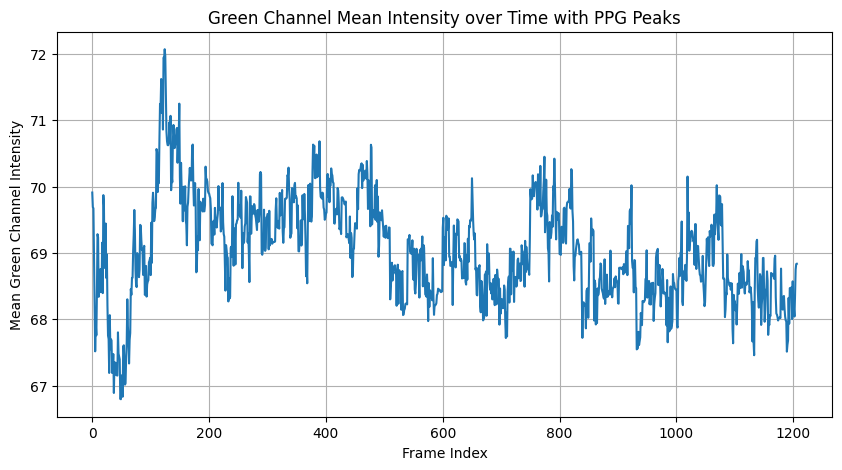

In [42]:
# Cohface 데이터셋 경로 설정
dataset_folder = "/content/drive/MyDrive/everglow/cohface/1/1/"

# 비디오 파일 로드 및 전처리
video_path = f"{dataset_folder}/data.avi"
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)

# PPG 데이터 로드
hdf5_path = f"{dataset_folder}/data.hdf5"
with h5py.File(hdf5_path, "r") as hf:
    pulse_data = np.array(hf['pulse'])
    respiration_data = np.array(hf['respiration'])
    time_data = np.array(hf['time'])

# Mediapipe Face 모듈을 로드합니다.
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.5)

# PPG peak detection 함수 정의
def detect_peaks(data, threshold=0.5):
    peaks = np.where(data > threshold)[0]
    return peaks

# 비디오 프레임을 읽어와서 Green 채널의 평균 강도 추출
green_channel_intensities = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # BGR 이미지를 RGB 이미지로 변환
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # 얼굴 감지
    results = face_detection.process(frame_rgb)
    if results.detections:
        # 여러 얼굴이 감지되더라도 첫 번째 얼굴만 사용합니다.
        detection = results.detections[0]
        bboxC = detection.location_data.relative_bounding_box
        ih, iw, _ = frame.shape
        x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)
        face_roi = frame[y:y+h, x:x+w]

        # Green 채널 추출 및 평균 강도 계산
        green_channel = face_roi[:, :, 1]  # Green 채널은 [G, B, R]에서 인덱스 1에 해당합니다.
        green_channel_mean = np.mean(green_channel)
        green_channel_intensities.append(green_channel_mean)

# Green 채널의 평균 강도에서의 PPG peak 탐지
green_peaks_list = detect_peaks(np.array(green_channel_intensities), threshold=0.5)

# Green 채널의 평균 강도 시각화
plt.figure(figsize=(10, 5))
plt.plot(green_channel_intensities)
# plt.scatter(green_peaks_list, np.array(green_channel_intensities)[green_peaks_list], c='r', marker='o')
plt.title('Green Channel Mean Intensity over Time with PPG Peaks')
plt.xlabel('Frame Index')
plt.ylabel('Mean Green Channel Intensity')
plt.grid(True)
plt.show()

# 비디오 처리 완료 후 해제
cap.release()

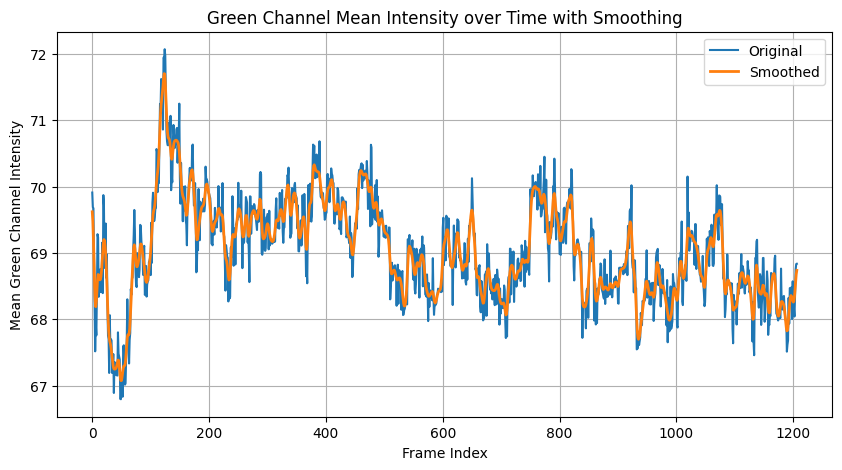

In [41]:
# Green 채널의 평균 강도에 Gaussian smoothing 적용
smoothed_green_channel = gaussian_filter(green_channel_intensities, sigma=2)

# Green 채널의 평균 강도와 스무딩된 신호 시각화
plt.figure(figsize=(10, 5))
plt.plot(green_channel_intensities, label='Original')
plt.plot(smoothed_green_channel, label='Smoothed', linewidth=2)
plt.title('Green Channel Mean Intensity over Time with Smoothing')
plt.xlabel('Frame Index')
plt.ylabel('Mean Green Channel Intensity')
plt.legend()
plt.grid(True)
plt.show()

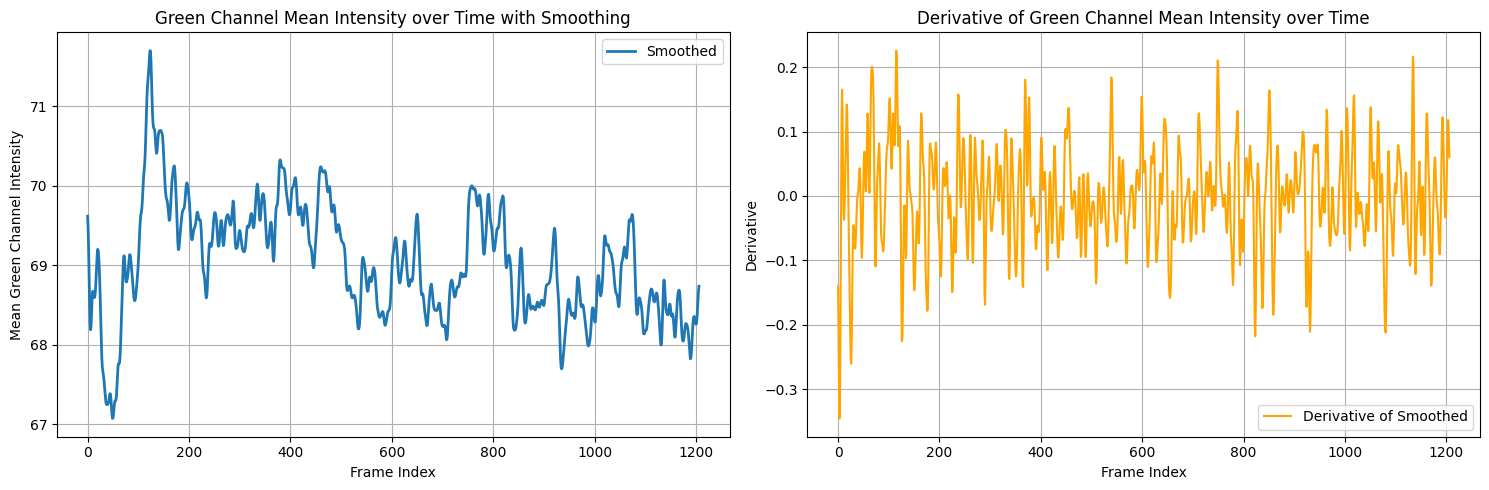

In [45]:
# 미분을 계산하기 위한 함수 정의
def derivative(signal):
    # 중앙 차분을 사용하여 미분 계산
    return np.gradient(signal)

# 스무딩된 신호의 미분 계산
diff_smoothed_green_channel = derivative(smoothed_green_channel)

# 스무딩된 신호와 미분된 신호 시각화
plt.figure(figsize=(15, 5))

# 원본 신호 그래프
plt.subplot(1, 2, 1)
# plt.plot(green_channel_intensities, label='Original')
plt.plot(smoothed_green_channel, label='Smoothed', linewidth=2)
plt.title('Green Channel Mean Intensity over Time with Smoothing')
plt.xlabel('Frame Index')
plt.ylabel('Mean Green Channel Intensity')
plt.legend()
plt.grid(True)

# 미분된 신호 그래프
plt.subplot(1, 2, 2)
plt.plot(diff_smoothed_green_channel, label='Derivative of Smoothed', color='orange')
plt.title('Derivative of Green Channel Mean Intensity over Time')
plt.xlabel('Frame Index')
plt.ylabel('Derivative')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

푸리에 변환을 사용하지 않고 시간 도메인에서 직접 피크 간격을 측정함으로써 BPM을 추정할 수 있음.

이 방법은 주로 실시간 또는 단일 시계열 데이터에 적합하며, 심박수와 같이 규칙적인 사이클을 가진 생체 신호에서 특히 유용함

In [47]:
# 피크 찾기
peaks, _ = find_peaks(smoothed_green_channel, distance=fps/2)  # 최소 BPM을 가정하여 distance 설정

# 피크 간의 간격 계산 (프레임 단위)
peak_intervals = np.diff(peaks)

# 프레임 간격을 시간(초)으로 변환
peak_intervals_in_seconds = peak_intervals / fps

# BPM 계산
bpm_values = 60 / peak_intervals_in_seconds

# 평균 BPM 계산
average_bpm = np.mean(bpm_values)

print(f"Average BPM: {average_bpm}")

Average BPM: 76.2022095479142
